#%%

# Dimension Reduction with Singular Value Decomposition (SVD) in Spark
 SVD on Spotify data
 load and preprocess data

In [1]:
#%%

from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.sql import SparkSession, Row
from pyspark.ml.linalg import Vectors
from pyspark.mllib.feature import StandardScaler as StandardScalerRDD
from pyspark.mllib.linalg.distributed import RowMatrix
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType, ArrayType
import numpy as np
import matplotlib.pyplot as plt
from datetime import date


spark = SparkSession \
        .builder \
        .appName("ITR3_svd") \
        .getOrCreate()

# Load Spotify data
df = spark.read.parquet('/home/mikezhu/music/data/spotify2020_preprocessed.parquet') 

print("number of rows (processed):",df.count())
df.printSchema()

24/12/10 22:53:39 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
number of rows (processed): 555910
root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- explicit: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- id_artists: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- danceability: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- key: float (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: float (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- acousticness: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveness: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- time_signature: float (nullable = true)
 |-- duration: double (nullable = true)
 |-- year: integer (nullable = true)



In [2]:
#%%

# vectorize features
feature_cols = [
    #'explicit',
    #'liveness', 
    'energy',
    'loudness',
    'danceability',
    'valence',
    'tempo',
    'time_signature',
    'acousticness',
    'instrumentalness',
    'mode',
    'duration',
    'key',
    'speechiness'
]
df_features = df.select(*(F.col(c) for c in feature_cols),'id') \
                         .dropna()
df_features = df_features.withColumn('features', F.array(*[F.col(c) for c in feature_cols])) \
                         .select('id', 'features')
df_features.show(5, truncate=False)

+----------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id                    |features                                                                                                                                                                                 |
+----------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|5HO9F0nzt2FGCvwYAuTmoW|[0.4699999988079071, -10.0, 0.5400000214576721, 0.5009999871253967, 171.9759979248047, 4.0, 0.2630000114440918, 0.0, 1.0, 3.9148833333333335, 0.0, 0.026599999517202377]                 |
|5H0ZfIuXw3qEXn2E1EasWX|[0.44699999690055847, -8.0, 0.902999997138977, 0.6110000014305115, 105.02999877929688, 4.0, 0.0210999995470047, 0.0, 1.0, 3.60821666

In [3]:
# %%

def find_optimal_svd_components(mat, threshold=0.95, max_k=10):
    """
    Find optimal number of singular values by analyzing explained variance
    
    Args:
        mat: RowMatrix (standardized) to perform SVD on
        threshold: Minimum cumulative explained variance ratio (default 0.95)
        max_k: Maximum number of components to try (default 10)
        
    Returns:
        optimal_k: Optimal number of components
        svd: Final SVD result with optimal_k components
        explained_variances: Array of explained variance ratios
    """
    # Try max_k components first to analyze variance
    svd_full = mat.computeSVD(max_k, computeU=True)
    s = svd_full.s.toArray()
    
    # Calculate explained variance ratios
    explained_variances = np.square(s) / np.sum(np.square(s))
    cumulative_variance = [sum(explained_variances[:i+1]) for i in range(len(explained_variances))]
    
    # Print variance explained by each component
    for i, var in enumerate(explained_variances):
        print(f"Component {i+1} explained variance: {var:.4f}")
        print(f"Cumulative explained variance: {cumulative_variance[i]:.4f}")
    
    # Find optimal number of components
    optimal_k = next((i + 1 for i, cum_var in enumerate(cumulative_variance) 
                     if cum_var >= threshold), max_k)
    
    # Plot explained variance analysis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot scree plot
    ax1.plot(range(1, len(explained_variances) + 1), explained_variances, marker='o')
    ax1.set_xlabel('Singular Value')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.set_title('Scree Plot')
    ax1.axvline(x=optimal_k, color='r', linestyle='--', 
                label=f'Optimal number of components ({optimal_k})')
    ax1.legend()
    
    # Plot cumulative variance
    ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    ax2.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    ax2.legend()
    ax2.set_xlabel('Singular Value')
    ax2.set_ylabel('Cumulative Explained Variance Ratio')
    ax2.set_title('Cumulative Explained Variance Plot')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nOptimal number of components: {optimal_k}")
    
    # Compute final SVD with optimal_k
    final_svd = mat.computeSVD(optimal_k, computeU=True)
    
    return optimal_k, final_svd, explained_variances

24/12/10 22:54:05 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/12/10 22:54:05 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
Component 1 explained variance: 0.9273
Cumulative explained variance: 0.9273
Component 2 explained variance: 0.0198
Cumulative explained variance: 0.9472
Component 3 explained variance: 0.0096
Cumulative explained variance: 0.9567
Component 4 explained variance: 0.0080
Cumulative explained variance: 0.9648
Component 5 explained variance: 0.0072
Cumulative explained variance: 0.9719
Component 6 explained variance: 0.0067
Cumulative explained variance: 0.9786
Component 7 explained variance: 0.0062
Cumulative explained variance: 0.9849
Component 8 explained variance: 0.0059
Cumulative explained variance: 0.9908
Component 9 explained variance: 0.0057
Cumulative explained variance: 0.9965
Component 10 explained variance: 0.0035
Cumulative explained variance: 1.0000


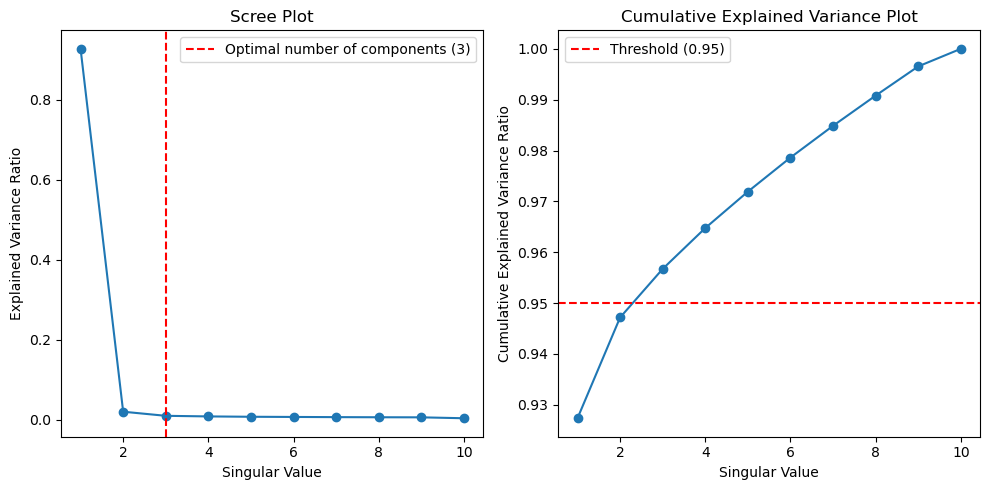


Optimal number of components: 3


24/12/10 22:54:07 WARN InstanceBuilder$NativeARPACK: Failed to load implementation from:dev.ludovic.netlib.arpack.JNIARPACK
24/12/10 22:54:07 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/12/10 22:54:07 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


DataFrame[features: vector]

In [4]:
# %%

# SVD only works on RDD, so we need to convert to RDD
vectors_rdd = df_features.rdd.map(lambda row: row["features"])
# standardize the data
standardizer_rdd = StandardScalerRDD()
model = standardizer_rdd.fit(vectors_rdd)
vectors_rdd = model.transform(vectors_rdd)
mat = RowMatrix(vectors_rdd)

# Compute SVD, using data-driven method to determine the number of components: 95% as threshold
optimal_k, svd, explained_variances = find_optimal_svd_components(mat, threshold=0.95)

# Access SVD components
U = svd.U
s = svd.s
V = svd.V

# convert U to DataFrame (and persist to memory) for visualization
U_df = U.rows.map(lambda row: Row(features=Vectors.dense(row.toArray()))) \
             .toDF()
U_df.persist()

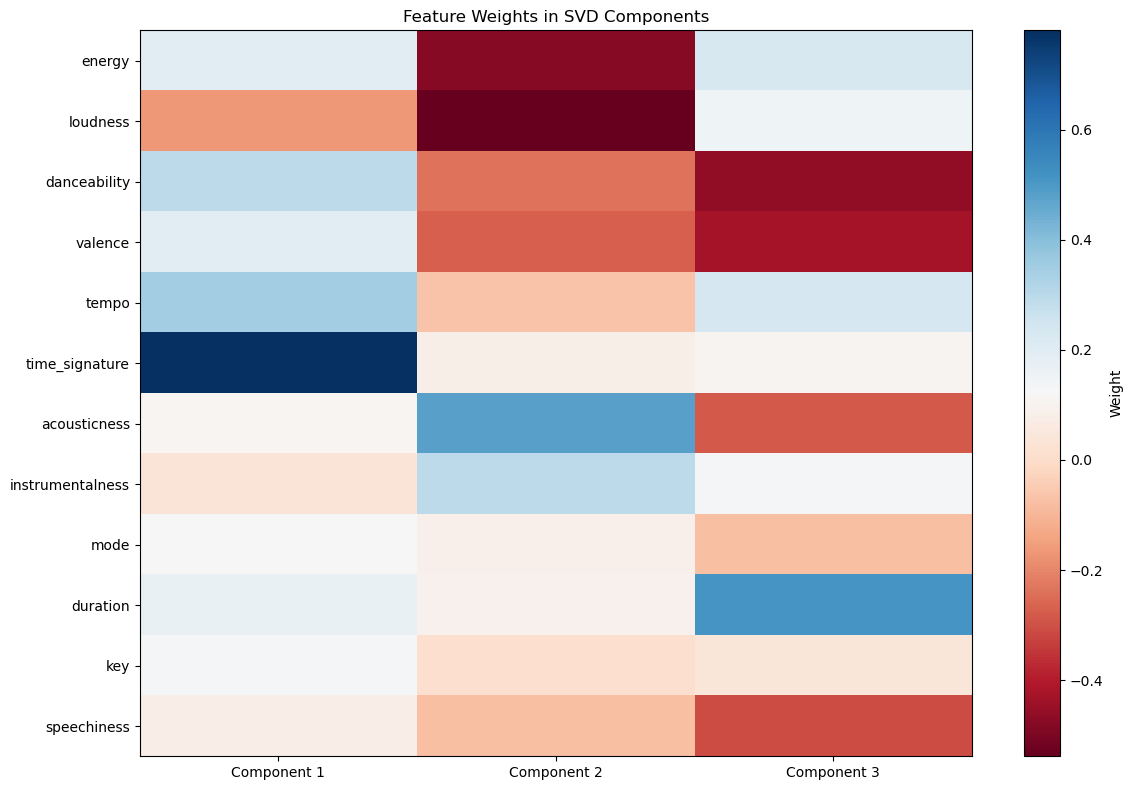

In [5]:
# %%

def analyze_components(V, feature_cols, n_components=None, figsize=(12, 8)):
    """
    Analyze and visualize the composition of SVD components in terms of original features
    
    Args:
        V: Right singular vectors matrix from SVD
        feature_cols: List of original feature names
        n_components: Number of components to analyze (default: all)
        figsize: Figure size for the plot
    """
    # Convert V to numpy array for easier manipulation
    V_np = V.toArray()
    
    if n_components is None:
        n_components = V_np.shape[1]
    
    # Create a heatmap of feature contributions
    plt.figure(figsize=figsize)
    plt.imshow(V_np[:, :n_components], cmap='RdBu', aspect='auto')
    plt.colorbar(label='Weight')
    plt.xticks(range(n_components), [f'Component {i+1}' for i in range(n_components)])
    plt.yticks(range(len(feature_cols)), feature_cols)
    plt.title('Feature Weights in SVD Components')
    plt.tight_layout()
    plt.show()

analyze_components(V, feature_cols, n_components=optimal_k)

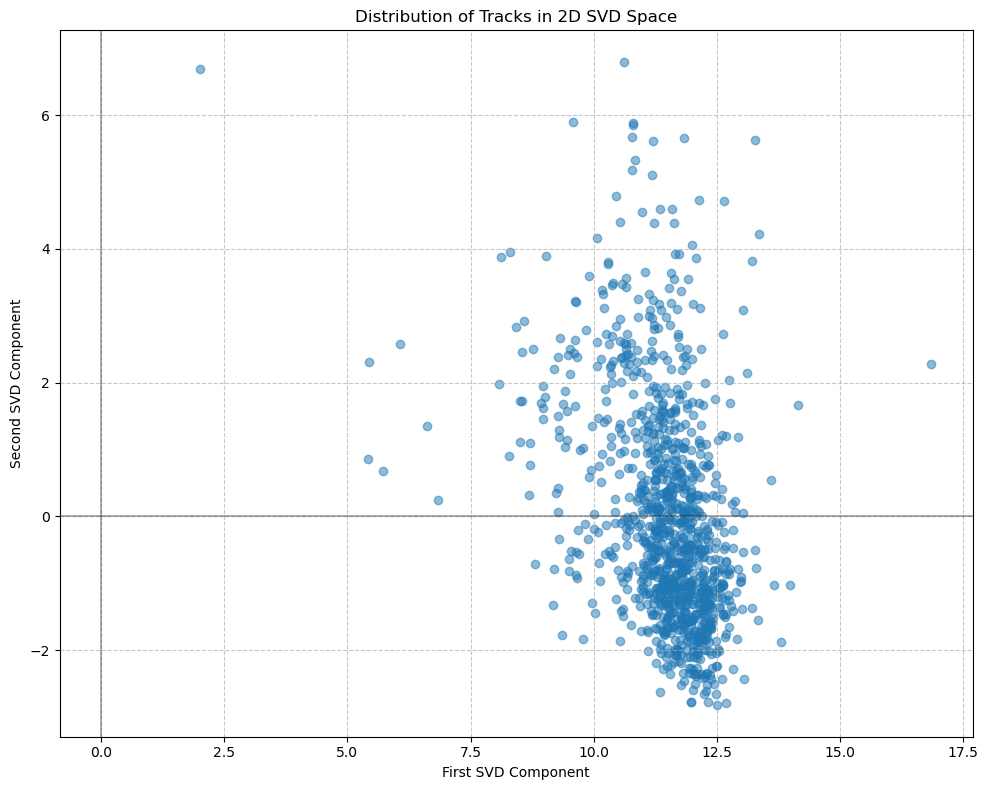

In [6]:
# %%

def plot_2d_distribution(U_df_array, s, sample_size=1000, figsize=(10, 8)):
    """
    Plot 2D distribution of tracks in the reduced SVD space
    """
    # Extract components from the array and scale by singular values
    samples = U_df_array.select(
        (F.col("features_array").getItem(0) * s[0]).alias("dim1"),
        (F.col("features_array").getItem(1) * s[1]).alias("dim2")
    ).sample(False, fraction=sample_size / U_df.count()).toPandas()

    # Plotting
    plt.figure(figsize=figsize)
    plt.scatter(samples["dim1"], samples["dim2"], alpha=0.5)
    plt.xlabel("First SVD Component")
    plt.ylabel("Second SVD Component")
    plt.title("Distribution of Tracks in 2D SVD Space")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.axhline(y=0, color="k", linestyle="-", alpha=0.3)
    plt.axvline(x=0, color="k", linestyle="-", alpha=0.3)
    plt.tight_layout()
    plt.show()

vector_to_array = F.udf(lambda vector: vector.toArray().tolist(), ArrayType(DoubleType()))
U_df_array = U_df.withColumn('features_array', vector_to_array(F.col('features')))
plot_2d_distribution(U_df_array,s)

In [7]:
# %%

# Merge U_df first component with df
first_component_df = U_df_array.select(F.monotonically_increasing_id().alias('row_id'), 
        F.col('features_array').getItem(0).alias('first_component'))
df_with_id = df.withColumn('row_id', F.monotonically_increasing_id())
df_with_component = df_with_id.join(first_component_df, 'row_id')
df_with_component.filter(F.col('first_component') < 7.5/s[0])\
    .select('name', 'artists', 'first_component', 'loudness', 'time_signature', 'energy', 'danceability') \
    .orderBy('first_component') \
    .show(10, truncate=False)
print("Those outliers are white noise, they shouldn't bias the component space")

+----------------------------------------------------------+------------------------------------------------------------------------------------------------------------+---------------------+--------+--------------+-------+------------+
|name                                                      |artists                                                                                                     |first_component      |loudness|time_signature|energy |danceability|
+----------------------------------------------------------+------------------------------------------------------------------------------------------------------------+---------------------+--------+--------------+-------+------------+
|Sold                                                      |['Apocolothoth']                                                                                            |3.941683506931005E-5 |3.0     |0.0           |0.114  |0.0         |
|Baby White Noise                                   